特徴量の重みを正常に反映しているか確認するため、オッズ系統を全て抜いて学習させる。

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
data_dir = "F:/TARGET frontier/TXT34/"
data_name = "train"
tail = "fe2_1"
train_data = pd.read_csv(data_dir+data_name+tail+".csv",encoding="shift-jis",dtype={'レースID(旧)':str})
#test_data
test_data = pd.read_csv(data_dir+"predict"+tail+".csv",encoding="shift-jis",dtype={'レースID(旧)':str})

In [3]:
pd.set_option('display.max_columns', 170)
train_data.head()

,レースID(旧),場所,芝・ダ,距離,クラス名,馬場状態,頭数,騎手,枠番,性別,年齢,キャリア,斤量,間隔,休み明け〜戦目,種牡馬,父タイプ名,所属,調教師,確定着順,着差,単勝オッズ,複勝オッズ下限,複勝オッズ上限,複勝配当,前走レースID(旧),前走場所,前芝・ダ,前距離,前クラス名,前走馬場状態,前走出走頭数,替,前騎手,前走枠番,前走脚質,前走斤量,前走Ave-3F,前走上り3F,前走PCI3,前走RPCI,前PCI,前好走,前走確定着順,前走着差タイム,前走単勝オッズ,場所距離芝ダ,前走場所距離芝ダ,前走レースID(旧)1,前走場所1,前芝・ダ1,前距離1,前クラス名1,前走馬場状態1,前走出走頭数1,替1,前騎手1,前走枠番1,前走脚質1,前走斤量1,前走Ave-3F1,前走上り3F1,前走PCI31,前走RPCI1,前PCI1,前好走1,前走確定着順1,前走着差タイム1,前走単勝オッズ1,場所距離芝ダ1,前走場所距離芝ダ1,前走レースID(旧)2,前走場所2,前芝・ダ2,前距離2,前クラス名2,前走馬場状態2,前走出走頭数2,替2,前騎手2,前走枠番2,前走脚質2,前走斤量2,前走Ave-3F2,前走上り3F2,前走PCI32,前走RPCI2,前PCI2,前好走2,前走確定着順2,前走着差タイム2,前走単勝オッズ2,場所距離芝ダ2,前走場所距離芝ダ2,前走レースID(旧)3,前走場所3,前芝・ダ3,前距離3,前クラス名3,前走馬場状態3,前走出走頭数3,替3,前騎手3,前走枠番3,前走脚質3,前走斤量3,前走Ave-3F3,前走上り3F3,前走PCI33,前走RPCI3,前PCI3,前好走3,前走確定着順3,前走着差タイム3,前走単勝オッズ3,場所距離芝ダ3,前走場所距離芝ダ3,前走レースID(旧)4,前走場所4,前芝・ダ4,前距離4,前クラス名4,前走馬場状態4,前走出走頭数4,替4,前騎手4,前走枠番4,前走脚質4,前走斤量4,前走Ave-3F4,前走上り3F4,前走PCI34,前走RPCI4,前PCI4,前好走4,前走確定着順4,前走着差タイム4,前走単勝オッズ4,場所距離芝ダ4,前走場所距離芝ダ4,前走レースID(旧)5,前走場所5,前芝・ダ5,前距離5,前クラス名5,前走馬場状態5,前走出走頭数5,替5,前騎手5,前走枠番5,前走脚質5,前走斤量5,前走Ave-3F5,前走上り3F5,前走PCI35,前走RPCI5,前PCI5,前好走5,前走確定着順5,前走着差タイム5,前走単勝オッズ5,場所距離芝ダ5,前走場所距離芝ダ5
0,0615581112,2,2,1200,5,3,16,491,6,2,3,13,56.0,6.0,5.0,669,8,0,363,1,0.0,5.4,1.9,2.7,190.0,0515531003,14,2,1400.0,5,2,15.0,0,330,2.0,3,54.0,37.2,33.9,59.53,58.2,59.7,0,8.0,0.2,14.6,49,49,0815411013,3.0,2.0,1400.0,5.0,3.0,18.0,0.0,430.0,7.0,2.0,53.0,35.03,34.0,54.30,51.8,53.0,0.0,8.0,0.3,10.1,32.0,180.0,0115211003,13.0,2.0,1200.0,4.0,3.0,16.0,0.0,99.0,2.0,2.0,54.0,34.1,34.8,47.77,44.6,48.0,0.0,1.0,0.0,15.3,67.0,39.0,0115111005,13.0,2.0,1500.0,4.0,3.0,14.0,0.0,77.0,4.0,2.0,54.0,35.53,35.6,50.73,49.1,49.8,0.0,6.0,0.9,10.3,24.0,40.0,0515220605,14.0,2.0,1600.0,4.0,3.0,9.0,0.0,330.0,5.0,3.0,56.0,36.90,34.2,59.07,57.7,57.9,0.0,6.0,0.4,6.3,25.0,50.0,0915250603,26.0,2.0,1600.0,4.0,4.0,12.0,0.0,245.0,3.0,4.0,56.0,36.66,35.8,53.87,47.9,52.4,0.0,7.0,1.1,22.6,33.0,149.0
1,0615581111,2,2,1200,5,3,16,77,6,1,3,10,54.0,3.0,3.0,530,8,0,362,2,0.0,2.8,1.3,1.6,130.0,0715420613,1,2,1200.0,4,3,18.0,1,77,7.0,3,54.0,34.5,34.6,48.80,46.9,49.7,0,1.0,0.0,2.2,49,14,0315350913,19.0,2.0,1200.0,4.0,4.0,16.0,0.0,307.0,7.0,3.0,53.0,35.30,36.4,48.27,47.0,47.0,0.0,2.0,0.4,2.0,7.0,85.0,0115230707,13.0,2.0,1200.0,4.0,3.0,16.0,0.0,349.0,4.0,2.0,52.0,34.4,34.5,49.43,47.4,49.7,0.0,2.0,0.2,2.9,43.0,39.0,0115140715,13.0,2.0,1200.0,4.0,3.0,16.0,1.0,349.0,8.0,2.0,52.0,34.00,34.4,47.23,44.3,48.8,0.0,2.0,0.0,7.6,24.0,39.0,0215260804,5.0,2.0,1200.0,4.0,2.0,16.0,1.0,349.0,2.0,3.0,52.0,34.80,36.0,47.07,45.0,46.7,0.0,2.0,0.0,4.2,24.0,215.0,0915310701,26.0,2.0,1400.0,10.0,3.0,18.0,0.0,77.0,1.0,3.0,54.0,35.18,35.3,50.30,48.2,49.6,0.0,1.0,0.0,2.0,77.0,148.0
2,0615581106,2,2,1200,5,3,16,245,3,2,3,9,56.0,5.0,2.0,707,5,1,241,3,0.2,6.2,1.8,2.5,180.0,0815551217,3,2,1200.0,5,3,18.0,0,159,8.0,2,56.0,34.5,34.4,50.13,48.0,50.3,0,7.0,0.4,28.6,49,177,0815381006,3.0,2.0,1200.0,18.0,3.0,16.0,0.0,449.0,3.0,2.0,56.0,34.80,34.1,51.90,50.0,52.1,0.0,9.0,0.9,118.0,66.0,177.0,0615281104,2.0,2.0,1800.0,13.0,3.0,12.0,0.0,353.0,4.0,5.0,56.0,37.3,37.3,60.53,58.1,50.0,1.0,11.0,2.8,327.2,66.0,109.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0615581108,2,2,1200,5,3,16,390,4,1,5,17,55.0,2.0,4.0,106,1,1,377,4,0.3,6.6,1.7,2.5,0.0,0615540911,2,2,1200.0,5,2,16.0,1,390,6.0,2,53.0,34.1,34.4,48.17,46.3,49.1,0,3.0,0.0,19.1,49,106,0815460915,3.0,2.0,1200.0,5.0,3.0,15.0,0.0,263.0,8.0,3.0,55.0,34.30,34.7,52.50,51.2,48.8,1.0,12.0,1.4,21.5,49.0,177.0,0615441005,2.0,2.0,1200.0,5.0,3.0,16.0,0.0,390.0,3.0,2.0,55.0,34.4,34.4,50.80,47.1,50.0,0.0,4.0,0.2,12.5,66.0,106.0,0315210805,19.0,2.0,1200.0,4.0,3.0,16.0,1.0,390.0,3.0,3.0,52.0,34.10,34.5,48.83,46.0,48.8,0.0,1.0,0.0,4.6,49.0,85.0,0415141210,12.0,2.0,1000.0,4.0,3.0,16.0,0.0,101.0,5.0,4.0,55.0,34.95,32.8,52.50,49.9,56.6,0.0,4.0,0.3,3.7,43.0,22.0,0315121201,19.0,2.0,1200

In [4]:
train_data.shape

(175352, 163)

In [5]:
"""droplist = []
for i in range(len(train_data)):
    if train_data.iloc[i]["馬場状態"] == 1: #不良
        droplist.append(i)
train_data = train_data.drop(droplist)
train_data = train_data.reset_index()

droplist = []
for i in range(len(test_data)):
    if test_data.iloc[i]["馬場状態"] == 1: #不良
        droplist.append(i)
test_data = test_data.drop(droplist)
test_data = test_data.reset_index()
"""

'droplist = []\nfor i in range(len(train_data)):\n    if train_data.iloc[i]["馬場状態"] == 1: #不良\n        droplist.append(i)\ntrain_data = train_data.drop(droplist)\ntrain_data = train_data.reset_index()\n\ndroplist = []\nfor i in range(len(test_data)):\n    if test_data.iloc[i]["馬場状態"] == 1: #不良\n        droplist.append(i)\ntest_data = test_data.drop(droplist)\ntest_data = test_data.reset_index()\n'

In [6]:
train_y = train_data["確定着順"]
test_y = test_data["確定着順"]

In [7]:
columns_name = ["レースID(旧)","場所","芝・ダ","距離","クラス名","馬場状態","頭数","騎手","枠番","性別","年齢","キャリア","斤量","間隔","休み明け〜戦目","種牡馬","父タイプ名","所属","調教師","確定着順","着差","単勝オッズ","複勝オッズ下限",
                "複勝オッズ上限","複勝配当","前走レースID(旧)","前走場所","前芝・ダ","前距離","前クラス名","前走馬場状態","前走出走頭数","替","前騎手","前走枠番","前走脚質","前走斤量","前走Ave-3F","前走上り3F","前走PCI3",
                "前走RPCI","前PCI","前好走","前走確定着順","前走着差タイム","前走単勝オッズ","場所距離芝ダ","前走場所距離芝ダ","前走レースID(旧)1","前走場所1","前芝・ダ1","前距離1","前クラス名1","前走馬場状態1","前走出走頭数1",
                "替1","前騎手1","前走枠番1","前走脚質1","前走斤量1","前走Ave-3F1","前走上り3F1","前走PCI31","前走RPCI1","前PCI1","前好走1","前走確定着順1","前走着差タイム1","前走単勝オッズ1","場所距離芝ダ1","前走場所距離芝ダ1",
                "前走レースID(旧)2","前走場所2","前芝・ダ2","前距離2","前クラス名2","前走馬場状態2","前走出走頭数2","替2","前騎手2","前走枠番2","前走脚質2","前走斤量2","前走Ave-3F2","前走上り3F2","前走PCI32","前走RPCI2",
                "前PCI2","前好走2","前走確定着順2","前走着差タイム2","前走単勝オッズ2","場所距離芝ダ2","前走場所距離芝ダ2","前走レースID(旧)3","前走場所3","前芝・ダ3","前距離3","前クラス名3","前走馬場状態3","前走出走頭数3",
                "替3","前騎手3","前走枠番3","前走脚質3","前走斤量3","前走Ave-3F3","前走上り3F3","前走PCI33","前走RPCI3","前PCI3","前好走3","前走確定着順3","前走着差タイム3","前走単勝オッズ3","場所距離芝ダ3","前走場所距離芝ダ3",
                "前走レースID(旧)4","前走場所4","前芝・ダ4","前距離4","前クラス名4","前走馬場状態4","前走出走頭数4","替4","前騎手4","前走枠番4","前走脚質4","前走斤量4","前走Ave-3F4","前走上り3F4","前走PCI34","前走RPCI4",
                "前PCI4","前好走4","前走確定着順4","前走着差タイム4","前走単勝オッズ4","場所距離芝ダ4","前走場所距離芝ダ4","前走レースID(旧)5","前走場所5","前芝・ダ5","前距離5","前クラス名5","前走馬場状態5","前走出走頭数5","替5",
                "前騎手5","前走枠番5","前走脚質5","前走斤量5","前走Ave-3F5","前走上り3F5","前走PCI35","前走RPCI5","前PCI5","前好走5","前走確定着順5","前走着差タイム5","前走単勝オッズ5","場所距離芝ダ5","前走場所距離芝ダ5",
               ]

In [27]:
#場所距離芝ダnは全部いらないデータ（前走はいる）
use_train_columns = ['場所', '芝・ダ', '距離', 'クラス名', '馬場状態', '騎手', '枠番', '性別', '年齢', 'キャリア',
       '斤量', '間隔', '休み明け〜戦目', '種牡馬', '父タイプ名', '調教師', '前走場所', '前芝・ダ', '前距離',
       '前クラス名', '前走馬場状態', '前騎手', '前走枠番', '前走脚質', '前走斤量', '前走Ave-3F',
       '前走上り3F', '前走PCI3', '前走RPCI', '前PCI', '前好走',  '前走着差タイム',
       '前走単勝オッズ', '単勝オッズ', '頭数', '場所距離芝ダ', '前走場所距離芝ダ']

In [28]:
train_x = train_data[use_train_columns]
test_x = test_data[use_train_columns]

In [29]:
#チューニング済みパラメータ(etaのみ手動)
params = {'colsample_bytree': 0.65, 
          'gamma': 0.013439667332810353, 
          'max_depth': 5, 
          'min_child_weight': 2.663317188920419, 
          'subsample': 0.9, 
          'booster': 'gbtree', 
          'objective': 'reg:squarederror', 
          'eta': 0.01, 
          'alpha': 0.0, 
          'lambda': 1.0, 
          'random_state': 71}

In [30]:
#これがないとエラー履くので注意
train_y.fillna(10,inplace=True) #無ければ10位に
test_y.fillna(10,inplace=True)

In [31]:
scores = []
histories = []
models = []
y = pd.Series()
kf = KFold(n_splits=4,shuffle=False)
for tr_idx,va_idx in kf.split(train_x):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    dtrain = xgb.DMatrix(tr_x,label=tr_y)
    dvalid = xgb.DMatrix(va_x,label=va_y)
    watchlist = [(dtrain,"train"),(dvalid,"eval")]
    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        early_stopping_rounds=100,
        evals=watchlist,
        evals_result=evals_result,
        verbose_eval=500
    )
    models.append(model)
    histories.append(evals_result)
    va_pred = model.predict(dvalid)
    va_y.fillna(0.5,inplace=True)
    score = mean_squared_error(va_y,va_pred)
    score = np.sqrt(mean_squared_error(va_y,va_pred)) #rmse
    scores.append(score)
    
    #evaluationさせる
    #全部のfoldについてyに入れておいて、
    y_pred_proba = model.predict(dvalid)
    y = pd.concat([y,pd.Series(y_pred_proba)])


output = train_data
output = output.assign(ya=y.values)
output["複勝配当"] = output["複勝配当"].astype("int64")
output.to_csv("C:/programs/HRP/kfeval.csv",index=False,encoding="shift-jis")
    
print(*scores)
print(np.mean(scores))

[0]	train-rmse:8.54469	eval-rmse:8.62863
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:3.49634	eval-rmse:3.55763
[1000]	train-rmse:3.45356	eval-rmse:3.53945
[1500]	train-rmse:3.4257	eval-rmse:3.53549
[2000]	train-rmse:3.40197	eval-rmse:3.53394
[2500]	train-rmse:3.37966	eval-rmse:3.53314
Stopping. Best iteration:
[2715]	train-rmse:3.37057	eval-rmse:3.53289

[0]	train-rmse:8.54411	eval-rmse:8.62922
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:3.49113	eval-rmse:3.56866
[1000]	train-rmse:3.44955	eval-rmse:3.5532
[1500]	train-rmse:3.42179	eval-rmse:3.54804
[2000]	train-rmse:3.39826	eval-rmse:3.54537
[2500]	train-rmse:3.37583	eval-rmse:3.54395
[3000]	train-rmse:3.35475	eval-rmse:3.54333
[3500]	train-rmse:3.33427	eval-rmse:3.5427
Stopping. Best iteration:
[3779]	tra

In [13]:
#学習結果のプロット
%matplotlib inline
def plot_loss(evals_result, title):
    train_metric = evals_result['train']['rmse']
    plt.plot(train_metric, label='train rmse')
    eval_metric = evals_result['eval']['rmse']
    plt.plot(eval_metric, label='eval rmse')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.xlabel('rounds')
    plt.ylabel('rmse')
    plt.show()

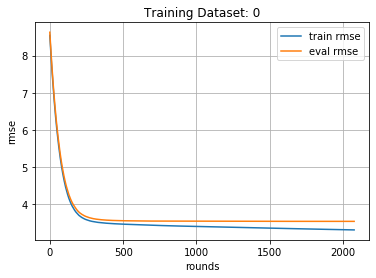

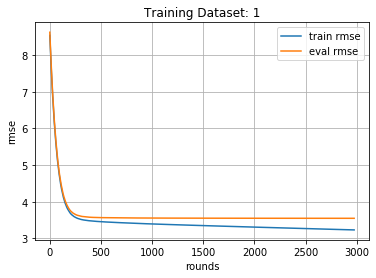

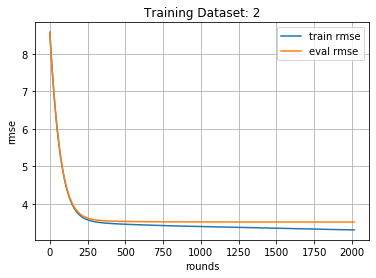

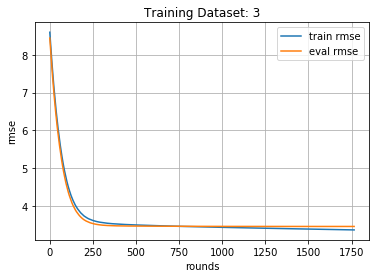

In [14]:
for i in range(4):
    plot_loss(histories[i],f'Training Dataset: {i}')

In [32]:
test_length = len(test_data)
predict = np.array([0.0]*test_length)
dtest = xgb.DMatrix(test_x,label=test_y) #本来は学習に使用していないデータにする
for i in range(4):
    y_pred_proba = models[i].predict(dtest)
    predict += y_pred_proba

predict /= 4

In [33]:
y = pd.DataFrame(predict,columns=["y'"])
output = test_data #ここも書き換えること

output = pd.concat([output,y],axis=1)

#output["複勝配当"] = output["複勝配当"].astype("int64")
output.to_csv("C:/programs/HRP/neweval7.csv",index=False,encoding="shift-jis")

In [17]:
fscore = model.get_score(importance_type="total_gain")
fscore = sorted([(k,v) for k,v in fscore.items()] ,key=lambda tpl: tpl[1], reverse = True)
print(*fscore[:20])

('単勝オッズ', 30341782.965607125) ('前走確定着順', 4808573.959471387) ('頭数', 4467156.530985405) ('前走単勝オッズ', 2743214.4056817624) ('前好走', 867788.5601420702) ('前走着差タイム', 803590.3830657587) ('間隔', 708698.7567905708) ('前走Ave-3F', 655747.0434776752) ('前走単勝オッズ1', 527564.9961604284) ('前PCI', 457852.55533637275) ('前走確定着順1', 431560.5214650504) ('前走脚質', 382668.4390444806) ('休み明け〜戦目', 368023.1009811959) ('騎手', 353133.9637378974) ('前走単勝オッズ2', 339674.5030467949) ('前走上り3F', 330477.158059873) ('種牡馬', 329237.5046566556) ('キャリア', 314746.0258661799) ('前距離', 293037.8446384638) ('調教師', 283090.26830611494)


In [18]:
#全体を100[%]とした時の重要度
mother = sum([j for i,j in fscore])
for i,j in fscore[:25]:
    print(i,round((j/mother)*100,1))

単勝オッズ 56.4
前走確定着順 8.9
頭数 8.3
前走単勝オッズ 5.1
前好走 1.6
前走着差タイム 1.5
間隔 1.3
前走Ave-3F 1.2
前走単勝オッズ1 1.0
前PCI 0.9
前走確定着順1 0.8
前走脚質 0.7
休み明け〜戦目 0.7
騎手 0.7
前走単勝オッズ2 0.6
前走上り3F 0.6
種牡馬 0.6
キャリア 0.6
前距離 0.5
調教師 0.5
クラス名 0.5
前クラス名 0.5
場所距離芝ダ 0.5
前走出走頭数 0.5
前騎手 0.5


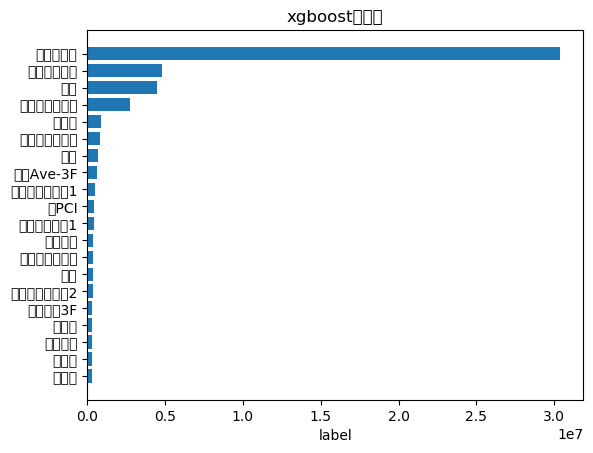

In [19]:
slen = 20
label = []
weight = []
for i,j in fscore[:slen]:
    label.append(i)
    weight.append(j)

plt.rcdefaults() #横棒グラフモード
fig, ax = plt.subplots()
y_pos = np.arange(slen)
ax.barh(y_pos, weight,align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(label)
ax.invert_yaxis()
ax.set_xlabel('label')
ax.set_title('xgboost特徴量')
plt.show()
    

In [20]:
#save models
import pickle
with open('xgmachina_ver0.1.0.pickle', mode='wb') as fp:
    pickle.dump(models, fp)

In [21]:
#import models
"""import pickle
with open('xgmachina_ver0.0.6.pickle', mode='rb') as fp:
    models = pickle.load(fp)"""

"import pickle\nwith open('xgmachina_ver0.0.6.pickle', mode='rb') as fp:\n    models = pickle.load(fp)"